Here , we are importing SparkSession from pyspark.sql to use sparksession to create a spark application that allows us to process data in distributed enviornments.

pyspark.sql - provides functionality to work with structured data using PySpark
Sparksession is the entry point to programming with Apache spark and SQL queries

In [1]:
from pyspark.sql import SparkSession

In the below cell , we are starting a SparkSession and naming out application to Business Analysis in Az.

In [2]:
spark = SparkSession.builder \
    .appName("Business Analysis in Arizona") \
    .getOrCreate()

24/11/19 19:20:42 WARN Utils: Your hostname, yelp resolves to a loopback address: 127.0.1.1; using 192.168.64.2 instead (on interface enp0s1)
24/11/19 19:20:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/19 19:20:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Here we are loading all the datasets

In [3]:
business_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")
review_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")
user_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_user.json")
tip_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_tip.json")
checkin_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_checkin.json")

24/11/19 19:20:56 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Filtering out business dataset only to focus on AZ state as our main interest.

In [4]:
AZ_business_df = business_df.filter(business_df["state"] == "AZ")

AZ_business_df.show(5)

+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|  city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|5255 E Broadway Blvd|{null, null, null...|tUFrWirKiKi_TAnsV...|Department Stores...|Tucson|{8:0-23:0, 8:0-22...|      0| 32.223236| -110.880452|              Target|      85711|          22|  3.5|   AZ|
|     625 N Stone Ave|{null, null, null...|rBmpy_Y1UbBx8ggHl...|Automotive, Auto ...|Tucson|{8:0-17:0, 0:0-0:...|      1|32.2298719|-110.9723419|Arizona Truck Out...|      85705|      

Converting json format to parquet for easy retrival of data

In [5]:
AZ_business_df.write.mode("overwrite").parquet("file:///home/dps/Documents/temp/AZ_business.parquet")
review_df.write.mode("overwrite").parquet("file:///home/dps/Documents/temp/review.parquet")
tip_df.write.mode("overwrite").parquet("file:///home/dps/Documents/temp/tip.parquet")
user_df.write.mode("overwrite").parquet("file:///home/dps/Documents/temp/user.parquet")
checkin_df.write.mode("overwrite").parquet("file:///home/dps/Documents/temp/checkin.parquet")

Code snippet to see which business categories are in AZ state

In [6]:
categories_AZ_business = AZ_business_df.select("categories").distinct()
categories_AZ_business.show(categories_AZ_business.count(), truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|categories                                                                                                                                                                                                                                                                                                                                                  |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

I want to choose Mexican restaurants as my category to do analysis on for this Project Milestone 1.

In [7]:
#filtering buinesses that are Mexican and also Restaurants
mexican_restaurants = AZ_business_df.filter(
    (AZ_business_df.categories.like("%Mexican%")) & (AZ_business_df.categories.like("%Restaurants%"))
)

mexican_restaurants_count = mexican_restaurants.count()
print("Number of mexican restaurants in AZ:" , mexican_restaurants_count)


Number of mexican restaurants in AZ: 548


### Query 1(Simple)
## Which cities in the AZ has the best and higher number of mexican restaurants?

Datasets used: 
1. business_df 


In [8]:
# registering mexican restaurant  as a temporary view
mexican_restaurants.createOrReplaceTempView("mexican_restaurants")

#query1
best_city = spark.sql("""
    SELECT 
        city, 
        AVG(stars) AS avg_rating,
        SUM(review_count) AS total_reviews
    FROM mexican_restaurants
    GROUP BY city
    ORDER BY avg_rating DESC
""")

# viewing result
best_city.show(best_city.count(),truncate=False)


+----------------+-----------------+-------------+
|city            |avg_rating       |total_reviews|
+----------------+-----------------+-------------+
|Drexel Heights  |4.5              |7            |
|Corona de Tucson|4.0              |19           |
|Tucson          |3.531311154598826|51360        |
|Vail            |3.5              |165          |
|tucson          |3.5              |155          |
|Catalina        |3.5              |169          |
|Green Valley    |3.4              |256          |
|Oro Valley      |3.34375          |1875         |
|Marana          |3.25             |388          |
|Sahuarita       |3.0              |91           |
+----------------+-----------------+-------------+



In [9]:
#viewing number of mexican restaurants in particular city
drexel_heights = mexican_restaurants.filter(mexican_restaurants["city"] == "Drexel Heights")
total_1 = drexel_heights.count()
print("Number of Mexican restaurants in Drexel Heights:", total_1)

corona_de_tucson = mexican_restaurants.filter(mexican_restaurants["city"] == "Corona de Tucson")
total_2 = corona_de_tucson.count()
print("Number of Mexican restaurants in Corona de Tucson:", total_2)

tucson = mexican_restaurants.filter(mexican_restaurants["city"] == "Tucson")
total_3 = tucson.count()
print("Number of Mexican restaurants in Tucson:", total_3)

vail = mexican_restaurants.filter(mexican_restaurants["city"] == "Vail")
total_4 = vail.count()
print("Number of Mexican restaurants in Vail:", total_4)

tuc = mexican_restaurants.filter(mexican_restaurants["city"] == "tucson")
total_5 = tuc.count()
print("Number of Mexican restaurants in tucson:", total_5)

catalina = mexican_restaurants.filter(mexican_restaurants["city"] == "Catalina")
total_6 = catalina.count()
print("Number of Mexican restaurants in Catalina:", total_6)

green_valley = mexican_restaurants.filter(mexican_restaurants["city"] == "Green Valley")
total_7 = green_valley.count()
print("Number of Mexican restaurants in Green Valley:", total_7)

oro_valley = mexican_restaurants.filter(mexican_restaurants["city"] == "Oro Valley")
total_8 = oro_valley.count()
print("Number of Mexican restaurants in Oro Valley:", total_8)

marana = mexican_restaurants.filter(mexican_restaurants["city"] == "Marana")
total_9 = marana.count()
print("Number of Mexican restaurants in Marana:", total_9)

sahuarita = mexican_restaurants.filter(mexican_restaurants["city"] == "Sahuarita")
total_10 = sahuarita.count()
print("Number of Mexican restaurants in Sahuarita:", total_10)



Number of Mexican restaurants in Drexel Heights: 1


Number of Mexican restaurants in Corona de Tucson: 1
Number of Mexican restaurants in Tucson: 511
Number of Mexican restaurants in Vail: 4
Number of Mexican restaurants in tucson: 1
Number of Mexican restaurants in Catalina: 1
Number of Mexican restaurants in Green Valley: 5
Number of Mexican restaurants in Oro Valley: 16
Number of Mexican restaurants in Marana: 4
Number of Mexican restaurants in Sahuarita: 4


In [10]:
import plotly.graph_objects as go

# Original data
cities = ["Drexel Heights","Corona de Tucson","Tucson","Vail","tucson","Catalina","Green Valley","Oro Valley","Marana","Sahuarita"]
counts = [1, 1, 511, 4, 1, 1, 5, 16, 4, 4]

# Create the bar graph with logarithmic scale
fig = go.Figure(data=[go.Bar(x=cities, y=counts)])

# Customize layout
fig.update_layout(
    title="Number of Mexican Restaurants by City",
    xaxis_title="Cities",
    yaxis_title="Number of Mexican Restaurants (Log Scale)",
    xaxis_tickangle=-45,
    yaxis=dict(type="log", title="Number of Restaurants (Log Scale)")
)

# Show the graph
fig.show()



### Query2 (Complex)
## Which city’s users give higher ratings (average stars) when reviewing Mexican restaurants?

Datasets used: 
1. business_df 
2. user_df
3. review_df

In [15]:
#registering datasets as temporary views
AZ_business_df.createOrReplaceTempView("arizona_businesses")
user_df.createOrReplaceTempView("users")
review_df.createOrReplaceTempView("reviews")

#query2
user_generosity = spark.sql("""
    SELECT 
        b.city,
        AVG(u.average_stars) AS avg_user_generosity
    FROM reviews r
    JOIN arizona_businesses b ON r.business_id = b.business_id
    JOIN users u ON r.user_id = u.user_id
    WHERE b.categories LIKE '%Mexican%'
    GROUP BY b.city
    ORDER BY avg_user_generosity DESC
""")

#viewing results
user_generosity.show(truncate=False)


+----------------+-------------------+
|city            |avg_user_generosity|
+----------------+-------------------+
|Drexel Heights  |4.488571428571428  |
|Corona de Tucson|4.064              |
|Tucson          |3.759104642870523  |
|Marana          |3.694490291262136  |
|Oro Valley      |3.6886054766734295 |
|tucson          |3.622621951219512  |
|Green Valley    |3.5853531598513    |
|Sahuarita       |3.4775789473684204 |
|Catalina        |3.4601744186046504 |
|Vail            |3.4572093023255808 |
+----------------+-------------------+



### Query 3 (Simple)
## Which restaurant is the most and highest reveiwed one?

Datasets used: 
1. business_df 

In [11]:
#query3
high_reviewed_restaurant = spark.sql("""
    SELECT 
        name, 
        city, 
        stars, 
        MAX(review_count) AS review_count
    FROM mexican_restaurants
    GROUP BY name, city, stars
    ORDER BY review_count DESC
    LIMIT 15
""")

#viewing the result
high_reviewed_restaurant.distinct().show(truncate=False)


+--------------------------------------------------------------+------+-----+------------+
|name                                                          |city  |stars|review_count|
+--------------------------------------------------------------+------+-----+------------+
|El Charro Cafe                                                |Tucson|3.5  |1583        |
|Cafe Poca Cosa                                                |Tucson|4.0  |1306        |
|Guadalajara Original Grill                                    |Tucson|4.0  |1117        |
|Mi Nidito Restaurant                                          |Tucson|4.0  |807         |
|Tucson Tamale Company                                         |Tucson|4.0  |806         |
|Street- Taco and Beer Co.                                     |Tucson|4.5  |805         |
|Blanco Tacos + Tequila                                        |Tucson|3.5  |739         |
|Boca Tacos Y Tequila                                          |Tucson|3.5  |730         |

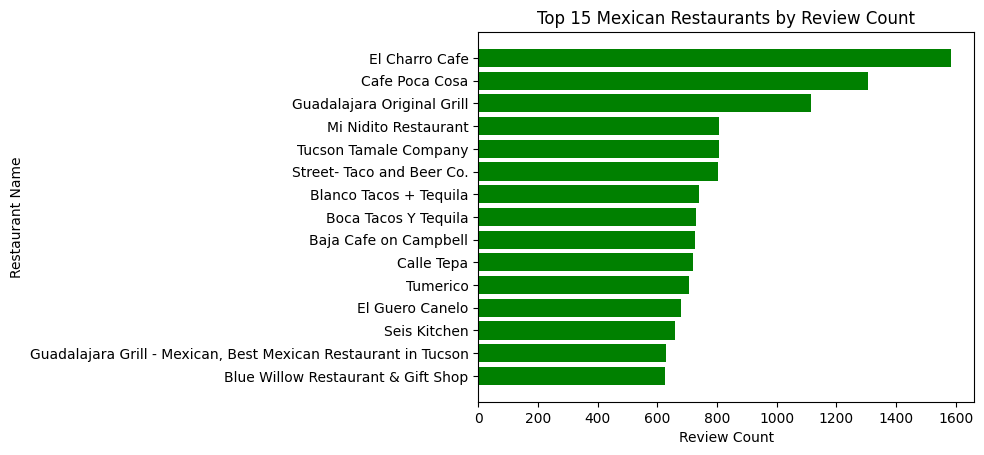

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

#converting to Pandas DataFrame
pandas_df = high_reviewed_restaurant.toPandas()

#plotting graph
plt.barh(pandas_df['name'], pandas_df['review_count'], color='green')
plt.xlabel('Review Count')
plt.ylabel('Restaurant Name')
plt.title('Top 15 Mexican Restaurants by Review Count')
plt.gca().invert_yaxis() 
plt.show()


### Query 4 (Complex)
## Which restaurants have highest compliments?

Datasets used: 
1. business_df 
2. tip_df

In [13]:
#registering the business and tips datasets as temporary views
AZ_business_df.createOrReplaceTempView("arizona_businesses")
tip_df.createOrReplaceTempView("tips")

#query4
high_compliments= spark.sql("""
    SELECT 
        b.name AS restaurant_name,
        b.city,
        b.stars AS avg_rating,
        SUM(t.compliment_count) AS total_compliments,
        COUNT(t.text) AS total_tips
    FROM arizona_businesses b
    JOIN tips t
    ON b.business_id = t.business_id
    WHERE b.categories LIKE '%Mexican%'
    GROUP BY b.name, b.city, b.stars
    ORDER BY total_compliments DESC
    LIMIT 15
""")

#viewing results
high_compliments.show(truncate=False)


+----------------------------------+--------+----------+-----------------+----------+
|restaurant_name                   |city    |avg_rating|total_compliments|total_tips|
+----------------------------------+--------+----------+-----------------+----------+
|Sir Veza's Taco Garage            |Tucson  |3.0       |9                |124       |
|Umi Star                          |Tucson  |4.0       |7                |60        |
|Poco & Mom's                      |Tucson  |4.0       |6                |160       |
|Gio Taco                          |Tucson  |3.5       |6                |53        |
|Sammy's Mexican Grill             |Catalina|3.5       |5                |54        |
|Taqueria Juanito's                |Tucson  |4.5       |5                |62        |
|Blue Willow Restaurant & Gift Shop|Tucson  |4.0       |5                |81        |
|El Charro Cafe                    |Tucson  |3.5       |5                |297       |
|Boca Tacos Y Tequila              |Tucson  |3.5      

### Query 5(Complex)
## Which top 10 popular users on yelp reviewed mexican restaurants in AZ?

Datasets used: 
1. business_df 
2. review_df
3. user_df


In [16]:
#registering datasets as temporary views
AZ_business_df.createOrReplaceTempView("arizona_businesses")
user_df.createOrReplaceTempView("users")
review_df.createOrReplaceTempView("reviews")

#query5
popular_user_review = spark.sql("""
    SELECT 
        b.name AS restaurant_name,
        b.city,
        b.stars AS avg_rating,
        u.name AS user_name,
        u.fans AS user_fans,
        r.stars AS review_rating,
        r.text AS review_text
    FROM reviews r
    JOIN arizona_businesses b ON r.business_id = b.business_id
    JOIN users u ON r.user_id = u.user_id
    WHERE b.categories LIKE '%Mexican%'
    ORDER BY u.fans DESC
    LIMIT 10
""")

# viewing the result
popular_user_review.show(truncate=False)


+------------------------------+------+----------+----------+---------+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------